# Goal: Find drivers of upsets in chess games and create a model to predict upsets 

* Upset is defined as a player with a lower rating winning a game agenst a player with a higher rating
* Model should make a predictions after having 'interviewed' each player as to thier intended opening as white and what defence they intend to use against a given opening as black

### Initial Thoughts

<br>

* Going into this project I am of two minds.

<br>

**First**
* Chess is a skill based game with no random elements (except assigning first move). 
* Because of this the player with the highest level of skill will win any game not determined by variation in player performance. 
* Because of this a given game will be won by the player with the highest level of skill a large majority of the time. * If this is true conditions underwhich variation in performance is the highest should result in the highest likelyhood of an upset.

<br>

**Second**
* It may also be the case that more skilled players are able to maintain consistancy better than less skilled players under conditions that would increased variation in thier performance.
* If this is true, those conditions may make upsets less likely as the variance would have a grater effect on the the less skilled player than on the more skilled player.

<br>

**Conclution**
* Though these two schools of thought may point at differing conclutions, both seem grounded in reason and I am eager to see what the data can tell us

### Initial Hypothisese About Drivers

* There will be few instances of upsets, possibly leading to an imbalanced data set
* As ratings for both players increase, the likelyhood of an upset will decrease 
* As the margin between player ratings increase the likelyhood of an upsets will decrease
* Shorter time incraments will increase the likelyhood of an upset
* Unranked games will have a higher likelyhood of an upset than ranked games
* Games where the higher rated player is moving the white pieces (gaining first move advantage) will have a decreased likelyhood of of an upset
* Some opening/defense stratagies may be more or less prone to upsets
* openings/defences that are more popular or perfered by higher rated players may be more/less prone to upset

# Imports

In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
import re

import wrangle as w

# Acquire

* Data acquired from Kaggle at https://www.kaggle.com/datasnaek/chess
* It contained 20,058 rows and 9 columns before cleaning

# Prepare

**Data was very clean initially, I performed the following steps to insure that is was ready for exploration:**
* Removed columns that did not contain useful information\* 
* Renamed columns to premote readability\*
* Checked for nulls in the data (there were none)
* Checked that column data types were ppropriate
* Removed white space from values in object columns
* There were no rows lost during preperation
* Added Target column 'upset' indicating weather the lower rated player won the game
* Added additional features to investigate (columns that could be calculated one row at a time)\*
* Split data into train, validate and test (approx. 60/20/20), stratifying on 'upset'
* Added additional features to investigate (columns that requiered an aggregate calculation by column)\*
* aggregat calculations were performed on train data
* resulting calculations were then applied to create columns in train, validate, and test data.

\* See data dictionary for full list

In [2]:
# acquiring, cleaning, and adding pre-split features to data
df = w.wrangle_chess_data(reprep = True)

# Splitting data into train, validate, and test
train, validate, test = w.split_my_data(df)

# Adding post split features to data
train, validate, test = w.fe_post_split(train, validate, test)

# Explore

### 1) Do upsets and non-upsets have a significantly differint number of moves

In [15]:
print(f"The mean number of moves for upsets are {train[train.upset == True].turns.mean()}.")

The mean number of moves for an upset is 61.637748164264345


In [16]:
print(f"The mean number of moves for a non-upset are {train[train.upset == False].turns.mean()}.")

The mean number of moves for a non-upset is 59.59827928524156.


**Given the small difference in means for these two groups it is unlikely that the two have a statistically significant difference. However, the data meets all of the conditions for a t-test. So lets see what the results are.**

**HO: The mean of moves in games that are upsets is not significantly differint from the mean of moves in games that are not upsets.**

**HA: The mean of moves in games that are upsets is significantly differint from the mean of moves in games that are not upsets.**

**I will be using a confidance interval of 95% resulting an an alpha of .05.**

In [21]:
stats.ttest_ind(train[train.upset == True].turns, train[train.upset == False].turns)

Ttest_indResult(statistic=3.0422082492257605, pvalue=0.0023539159816672317)

**Because the t-test resulted in a pvalue that was below the alpha, we have reason to believe that the mean of moves in games that are upsets is significantly differint from the mean of moves, even though the difference in those means is only about 2 moves.**

### 2) Does the lower rated player moving the white peices effect the likelyhood of an upset?

In [28]:
train[train.lower_rated_white == True].upset.mean()

0.35032198712051515

In [29]:
train[train.lower_rated_white == False].upset.mean()

0.3058478523374159

In [31]:
train.upset.mean()

0.32736823361823364

### Examine Object Variables

In [7]:
list(train.columns)

['rated',
 'turns',
 'ended_as',
 'winning_pieces',
 'time_code',
 'white_rating',
 'black_rating',
 'opening_code',
 'opening_name',
 'upset',
 'rating_dif',
 'game_rating',
 'lower_rated_white',
 'time_block',
 'time_minutes',
 'opening_code_pop',
 'opening_name_pop',
 'opening_code_high_pop',
 'opening_name_high_pop',
 'opening_code_top_pop',
 'opening_name_top_pop',
 'opening_code_low_pop',
 'opening_name_low_pop',
 'opening_code_rating_mean',
 'opening_code_rating_median',
 'opening_code_rating_max']

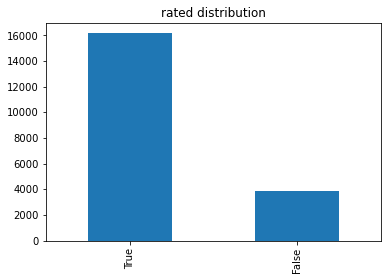

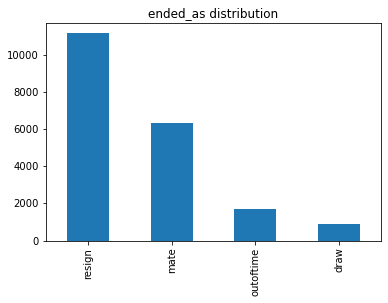

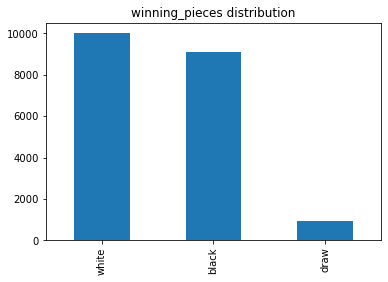

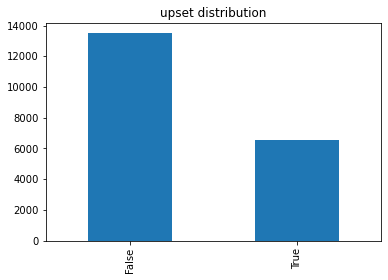

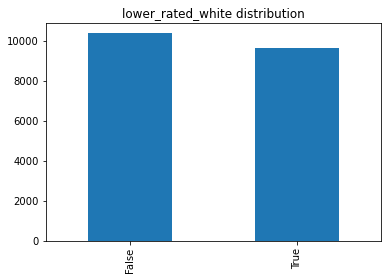

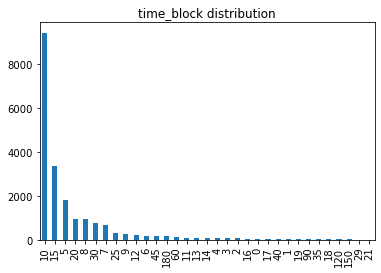

In [10]:
# distribution of the data
columns = ['rated',
           'ended_as',
           'winning_pieces',
           'upset',
           'lower_rated_white',
           'time_block',
          ]

for col in columns:
    
    df[col].value_counts().plot(kind='bar', title = f"{col} distribution")
    
    plt.show()

### Takeaways

* Resignations usually happen when mate is enevitable I see no reason to seperate the two
* I wonder if running out of time has an effect on upsets? 
* White does have an advantage, though it is much smaller than I thought it would be, at about 10% higher number of wins than black
* time_code, opening_code, and opening_name, have too many values to sort through at the moment and will have to be binned or pruened
* upsets represent about 1/3 or the data, which is higher than I thought it would be

### Examine Quantitative Variables

In [ ]:
# distribution of the data
cols = ['turns', 'white_rating', 'black_rating']

for col in cols:
    plt.hist(df[col])
    plt.title(col+' distripution')
    plt.show()

### Takeaways

* Turns is slightly right skewed 
* Black and white rating distributions are pretty normally distributed and are nearly if not entierly identical

In [ ]:
df.time_code.value_counts()

### I'm goint to try to prune the object columns by removing the values that do not have a significant represintation I an setting my trial cut off point at 50 or more occurrences 

In [ ]:
df.to_csv('games_preped.csv')
df = pd.read_csv('games_preped.csv')

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace = True)

In [ ]:
df.head()

In [ ]:
# distribution of the data
columns = ['ended_as', 'winning_pieces', 
           'time_code', 'opening_code', 
           'opening_name', 'upset']

for col in columns:
    
    df[col].value_counts().plot(kind='bar', title = f"{col} distribution")
    
    plt.show()